<a href="https://colab.research.google.com/github/Mary-prh/food_classification_transfer-learning-/blob/main/Food_type_detection_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explore Data**

In [ ]:
!nvidia-smi

Wed Apr  6 18:28:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-04-06 18:28:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.69.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   111MB/s    in 1.4s    

2022-04-06 18:28:19 (111 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirname)} directories and {len(filename)} image in {dirpath}')

there are 2 directories and 0 image in 10_food_classes_10_percent
there are 10 directories and 0 image in 10_food_classes_10_percent/train
there are 0 directories and 75 image in 10_food_classes_10_percent/train/grilled_salmon
there are 0 directories and 75 image in 10_food_classes_10_percent/train/fried_rice
there are 0 directories and 75 image in 10_food_classes_10_percent/train/chicken_wings
there are 0 directories and 75 image in 10_food_classes_10_percent/train/steak
there are 0 directories and 75 image in 10_food_classes_10_percent/train/ice_cream
there are 0 directories and 75 image in 10_food_classes_10_percent/train/pizza
there are 0 directories and 75 image in 10_food_classes_10_percent/train/sushi
there are 0 directories and 75 image in 10_food_classes_10_percent/train/chicken_curry
there are 0 directories and 75 image in 10_food_classes_10_percent/train/hamburger
there are 0 directories and 75 image in 10_food_classes_10_percent/train/ramen
there are 10 directories and 0 im

## Load the images in batches

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(rescale=1/255.)
test_gen =  ImageDataGenerator(rescale=1/255.)

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

Batch_Size = 32
Image_Shape = (224,224)

train_data = train_gen.flow_from_directory(train_dir,target_size = Image_Shape , 
                                           batch_size = Batch_Size, class_mode = 'categorical')

test_data = test_gen.flow_from_directory(test_dir,target_size = Image_Shape , 
                                           batch_size = Batch_Size, class_mode = 'categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
import numpy as np
import pathlib as pl

data_dir = pl.Path('10_food_classes_10_percent/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(f"There are {len(class_names)} classes named {class_names} in the data set.")

There are 10 classes named ['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi'] in the data set.


In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_images_randomly(folder, train_or_test , subfolder):
     # Setup target directory (we'll view images from here)
  target_folder = folder+'/'+train_or_test+'/'+subfolder

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image[0])

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(subfolder)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

6926.jpg
Image shape: (384, 512, 3)


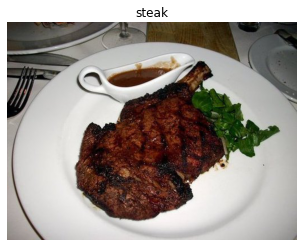

In [ ]:
img = view_images_randomly(folder="10_food_classes_10_percent", train_or_test="train",
                           subfolder=random.choice(class_names))

# **Creating models using TensorFlow Hub**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Model Creation

#  **Create tensorboard callback**

In [ ]:
import datetime
def tensorboard_callback_func(dir_name, model_name):
  Log_Dir = dir_name + '/' + model_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%m%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= Log_Dir)
  print(f"Saving TensorBoard log files to: {Log_Dir}")
  return tensorboard_callback

# **Hub Function**

In [ ]:
def transfer_model(model_url , classes):
  """Returns:
          An uncompiled Keras Sequential model with model_url as feature
          extractor layer and Dense output layer with classes outputs.
    """
  Feature_extraction_layer = hub.KerasLayer(model_url, trainable=False,
                                          input_shape = Image_Shape+(3,))

  model = Sequential()
  model.add(Feature_extraction_layer)
  model.add(Dense(classes ,activation='softmax'))
  return model

Copy the urls

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficientnetb7_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
resnet_model = transfer_model(resnet_url, len(class_names))

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Compiling the model

**Resnet Model**

In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='Adam', metrics=['accuracy'])

In [ ]:
history_1 = resnet_model.fit(train_data, steps_per_epoch= len(train_data),
                             validation_data= test_data, validation_steps=len(test_data),
                             epochs= 5)

Epoch 1/5
24/24 [==============================] - 42s 1s/step - loss: 1.8928 - accuracy: 0.3827 - val_loss: 1.1837 - val_accuracy: 0.6224
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9013 - accuracy: 0.7240 - val_loss: 0.8414 - val_accuracy: 0.7228
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6029 - accuracy: 0.8293 - val_loss: 0.7322 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4731 - accuracy: 0.8787 - val_loss: 0.7014 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3753 - accuracy: 0.9107 - val_loss: 0.6712 - val_accuracy: 0.7808


In [ ]:
import pandas as pd
losses_1 = pd.DataFrame(history_1.history)
losses_1

,loss,accuracy,val_loss,val_accuracy
0,1.892779,0.382667,1.183699,0.6224
1,0.901309,0.724000,0.841401,0.7228
2,0.602854,0.829333,0.732208,0.7624
3,0.473089,0.878667,0.701425,0.7720
4,0.375295,0.910667,0.671209,0.7808


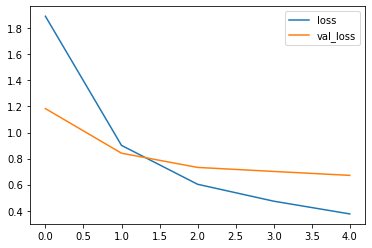

In [ ]:
losses_1[['loss','val_loss']].plot()

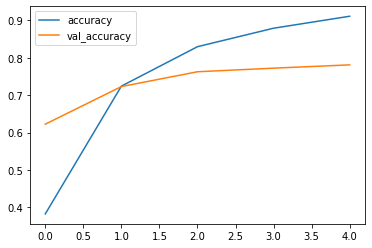

In [ ]:
losses_1[['accuracy','val_accuracy']].plot()

**Efficientnet b0 Model**

In [ ]:
efficient_model = transfer_model(efficient_url, len(class_names))

In [ ]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficient_model.compile(loss='categorical_crossentropy',
                     optimizer='Adam', metrics=['accuracy'])

In [ ]:
history_2 = efficient_model.fit(train_data, steps_per_epoch= len(train_data),
                             validation_data= test_data, validation_steps=len(test_data),
                             epochs= 5)

Epoch 1/5
24/24 [==============================] - 34s 987ms/step - loss: 1.8293 - accuracy: 0.4467 - val_loss: 1.2772 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 21s 879ms/step - loss: 1.0508 - accuracy: 0.7627 - val_loss: 0.8643 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 20s 866ms/step - loss: 0.7584 - accuracy: 0.8253 - val_loss: 0.6991 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 20s 880ms/step - loss: 0.6154 - accuracy: 0.8520 - val_loss: 0.6145 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 20s 871ms/step - loss: 0.5166 - accuracy: 0.8973 - val_loss: 0.5613 - val_accuracy: 0.8608


In [ ]:
losses_2 = pd.DataFrame(history_2.history)
losses_2

,loss,accuracy,val_loss,val_accuracy
0,1.829304,0.446667,1.277167,0.7360
1,1.050841,0.762667,0.864251,0.8204
2,0.758413,0.825333,0.699140,0.8396
3,0.615356,0.852000,0.614522,0.8500
4,0.516557,0.897333,0.561320,0.8608


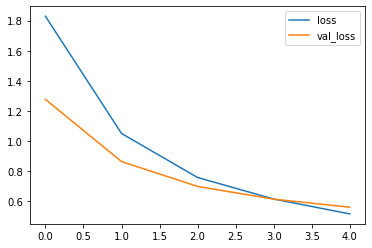

In [ ]:
losses_2[['loss','val_loss']].plot()

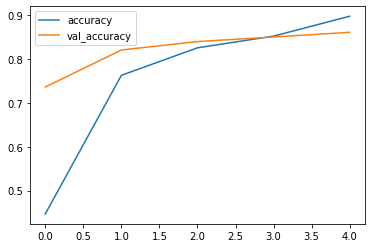

In [ ]:
losses_2[['accuracy','val_accuracy']].plot()

**Efficientnet b7 Model**

In [ ]:
efficientb7_model = transfer_model(efficientnetb7_url, len(class_names))

In [ ]:
efficientb7_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_6 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientb7_model.compile(loss='categorical_crossentropy',
                     optimizer='Adam', metrics=['accuracy'])

In [ ]:
from gc import callbacks
history_3 = efficientb7_model.fit(train_data, steps_per_epoch= len(train_data),
                             validation_data= test_data, validation_steps=len(test_data),
                             epochs= 5,callbacks= [tensorboard_callback_func(dir_name="tensorflow_hub", # save experiment logs here
                                                                         model_name="efficientnetb7")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb7/20220406-20041649276488
Epoch 1/5
24/24 [==============================] - 35s 931ms/step - loss: 1.8073 - accuracy: 0.4493 - val_loss: 1.2682 - val_accuracy: 0.7268
Epoch 2/5
24/24 [==============================] - 20s 873ms/step - loss: 1.0357 - accuracy: 0.7787 - val_loss: 0.8515 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 20s 873ms/step - loss: 0.7362 - accuracy: 0.8533 - val_loss: 0.6843 - val_accuracy: 0.8532
Epoch 4/5
24/24 [==============================] - 20s 875ms/step - loss: 0.5880 - accuracy: 0.8693 - val_loss: 0.6014 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 20s 872ms/step - loss: 0.4962 - accuracy: 0.9000 - val_loss: 0.5489 - val_accuracy: 0.8664


In [ ]:
losses_3 = pd.DataFrame(history_3.history)
losses_3

,loss,accuracy,val_loss,val_accuracy
0,1.849806,0.432000,1.315791,0.7284
1,1.063768,0.769333,0.867941,0.8192
2,0.752813,0.846667,0.694945,0.8484
3,0.602916,0.874667,0.610214,0.8580
4,0.508394,0.902667,0.556282,0.8652


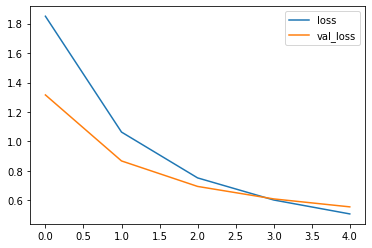

In [ ]:
losses_3[['loss','val_loss']].plot()

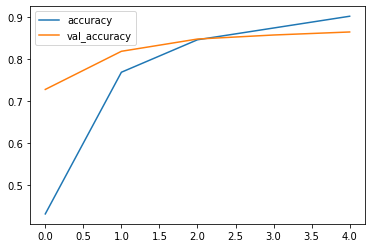

In [ ]:
losses_3[['accuracy','val_accuracy']].plot()

In [ ]:
len(efficientb7_model.layers[0].weights)

309

In [ ]:
efficientb7_model.save("trained_efficientnetb7_model")

INFO:tensorflow:Assets written to: trained_efficientnetb7_model/assets


INFO:tensorflow:Assets written to: trained_efficientnetb7_model/assets


In [ ]:
reloaded_model = tf.keras.models.load_model("trained_efficientnetb7_model")
reloaded_model.evaluate(test_data)

79/79 [==============================] - 18s 206ms/step - loss: 0.5563 - accuracy: 0.8652


[0.556282103061676, 0.8651999831199646]

## **Prediction**

In [ ]:
def predict_image (filename , img_shape , model, class_name):
  img  = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img , size = [img_shape , img_shape])
  img = img/255.
  plt.imshow(img)
  plt.axis(False)
  img = tf.expand_dims(img, axis=0)
  pred = model.predict(img)
  pred_class = class_name[pred.argmax()]
  plt.title(f"Prediction: {pred_class}")
  return pred_class

In [ ]:
!wget https://pyxis.nymag.com/v1/imgs/d0a/53e/abfcc8399bde3f1b197a6536e26c2bd277-ice-cream.2x.rsocial.w600.jpg

--2022-04-06 19:16:14--  https://pyxis.nymag.com/v1/imgs/d0a/53e/abfcc8399bde3f1b197a6536e26c2bd277-ice-cream.2x.rsocial.w600.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72099 (70K) [image/jpeg]
Saving to: ‘abfcc8399bde3f1b197a6536e26c2bd277-ice-cream.2x.rsocial.w600.jpg’

abfcc8399bde3f1b197 100%[===================>]  70.41K  --.-KB/s    in 0.01s   

2022-04-06 19:16:14 (5.81 MB/s) - ‘abfcc8399bde3f1b197a6536e26c2bd277-ice-cream.2x.rsocial.w600.jpg’ saved [72099/72099]



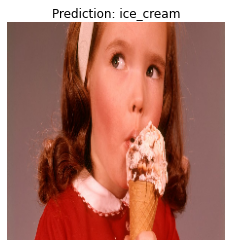

In [ ]:
result = predict_image('ice2.jpg', 224, efficientb7_model,class_names)

# Tensorboard

In [ ]:
%load_ext tensorboard
# %tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Effiecientnet-B7" \
  --one_shot 
#once uploading is done, it exits the uploader


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=CsqL4ZD00nkZKtLGKqiXVAGNFW7nQn&prompt=consent&access_type=off

TensorBoard link: https://tensorboard.dev/experiment/iQcAm7erQPOcxmOAygfwgw/ 